In [2]:
from tensorflow_probability.substrates import jax as tfp #this is tensorflow probability on jax 
import distrax

from jaxmarl import *
from jaxmarl.environments.multi_agent_env import MultiAgentEnv

from rapidae.models import Beta_VAE #rapidae is based on keras 3 which means a jax implementation is available
from rapidae.models.base import VanillaEncoder, VanillaDecoder

import numpyro
from numpyro import *
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import Predictive, SVI, Trace_ELBO
from pyro.infer.abstract_infer import TracePosterior
import pyro.poutine as poutine, queue
from pyro.contrib.oed.eig import marginal_eig, posterior_eig
#optimization
import optax
from optax.contrib import prodigy

from gymnax import *
import mo_gymnasium as mo_gym

import dynamax

from laplace import Laplace #for model selection 
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN

#bm4pml is for bayesian model reduction needed to simulate the way brain does structure learning for causal inference 
#from bmr4pml.models import SVIRegression, BMRRegression
#from bmr4pml.nn import MLP, LeNet, VisionTransformer, resnet18, MlpMixer
#from bmr4pml.datasets import load_data
#from bmr4pml.inference import fit_and_test
#from bmr4pml.nn.utils import PatchConvEmbed, PatchLinearEmbed

#utilities
import omegaconf
from hydra import *

from jax import *
import functools
from functools import partial
import jax.numpy as jnp

import chex
from flax import struct
import flax.linen as nn
from flax.linen.initializers import constant, orthogonal
from flax.training.train_state import TrainState
import flashbax as fbx
from flax.core import frozen_dict
import wandb
import hydra
from omegaconf import OmegaConf
from safetensors.flax import save_file
from flax.traverse_util import flatten_dict

from jaxmarl import make
from jaxmarl.wrappers.baselines import LogWrapper
from jaxmarl.environments.smax import map_name_to_scenario
from jaxmarl.environments.overcooked import overcooked_layouts
from functools import partial

# from gymnax.environments import environment, spaces
from gymnax.environments.spaces import Box as BoxGymnax, Discrete as DiscreteGymnax
from typing import Optional, List, Tuple, Union, NamedTuple, Dict
from jaxmarl.environments.spaces import Box, Discrete, MultiDiscrete
from jaxmarl.environments.multi_agent_env import MultiAgentEnv, State

from flowjax.flows import block_neural_autoregressive_flow
from flowjax.train import fit_to_data
from flowjax.distributions import Normal

import ivy

import zuko#uses normalizing flows that is for ELBO then what we have implemented in 
#from pyro.contrib.zuko import ZukoToPyro
from strnn.models.strNN import StrNN
from torch2jax import j2t, t2j
#hyperparameter optimization
import sherpa

#visualization
import taichi as ti
import taichi.math as tm
from ursina import *   

2024-09-21 18:28:38.037534: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/root/miniconda3/envs/rapids-23.04/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


[Taichi] version 1.6.0, llvm 15.0.4, commit f1c6fbbd, linux, python 3.10.11


[I 09/21/24 18:28:48.240 240089] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [3]:

import os
os.environ["KERAS_BACKEND"] = "jax"

import keras
import keras as K
from keras.layers import Input, Dense, Lambda
#from keras.layers.merge import concatenate as concat
from keras.models import Model

In [4]:
#from numpyro.contrib.oed.eig import posterior_eig
from numpyro.optim import Adam
#from numpyro.infer.abstract_infer import TracePosterior

overall objectives:

perception
learning
action
learning with full causal inference
consciousness 

stage 1 objectives

perception
action

achieved through implementation of standard EFE and VFE

stage 2 objectives

learning 
swap out all neural networks with either normalizing flows or tsetlin machines 
enhanced EFE and bayesian model reduction 

stage 3 objectives

consciousness
emotions


part of qmix is going to be reversed with the mixer networks firing before the Emodels and then bmodels networks 



In [ ]:
x = jnp.arange(10)
print(x)

brain has a energy budget of 20W per second 

In [ ]:
app = Ursina()
ground = Entity(
    model = 'cube',
    color = color.magenta,
    z = -.1,
    y = -3,
    origin = (0, .5),
    scale = (50, 1, 10),
    collider = 'box',
    )

#app.run()   

we may need to move the entire agent and scanned rnn below where the q_tot is calculated or raise b and e models so that we can use the generated q_tot with obs to find z, the individual q values

we do not need to raise b and emodels just add an extra argument representing q_tot

In [4]:
class ScannedRNN(nn.Module):

    @partial(
        nn.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False},
    )
    @nn.compact
    def __call__(self, carry, x):#keave scannedrnn the way it is 
        """Applies the module."""
        rnn_state = carry
        ins, resets = x
        hidden_size = ins.shape[-1]
        rnn_state = jnp.where(
            resets[:, jnp.newaxis],
            self.initialize_carry(hidden_size, *ins.shape[:-1]),
            rnn_state,
        )
        new_rnn_state, y = nn.LSTMCell(hidden_size)(rnn_state, ins)

        
        return new_rnn_state, y

    @staticmethod
    def initialize_carry(hidden_size, *batch_size):
        # Use a dummy key since the default state init fn is just zeros.
        return nn.LSTMCell(hidden_size, parent=None).initialize_carry(
            jax.random.PRNGKey(0), (*batch_size, hidden_size)
        )

In [5]:

class AgentRNN(nn.Module):
    # homogenous agent for parameters sharing, assumes all agents have same obs and action dim

    """"
    specifications for either scanned rnn or agent rnn: this agent will ahve to accept: observations, and qtot values in order to generate a
    individual q value 

    for the moment let us assume that obs will only be 1 row deep at each time step. Then all we need to do is determine which qvalues 
    corresponding to actions will allow us to get to qtot. This will need to be a variational autoencoder or we could use pyro or zuko.

    THis is because we know x: the observations and y qtot. We need to find z: the latent space that will allow us to get from x to y.

    We will for the moment be using a beta_vae. 

    we need a specific kind of variational autoencoder called a conditional variational autoencoder. we will use this https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb
        
    
    we should assume that q_vals has a dimensionalty of 2. n_y will simply be the shape of q_tot


    the decoding process is the reconstruction from z to X_hat.

    we need to do this reconstruction because at no point can we ever see what z is. This reconstruction is used to validate z which we can never observe

    x will be q_tot and y will be observations

    during the predict stage x will be fully available byt only a subset of y will be available. 
    """

    action_dim: int
    hidden_dim: int
    init_scale: float

    @nn.compact
    def __call__(self, hidden, x):#add extra argument y or labels which here will be q_tot
        obs, dones = x
        q_tot= 0 
        label = q_tot

        embedding = nn.Dense(self.hidden_dim, kernel_init=orthogonal(self.init_scale), bias_init=constant(0.0))(obs)
        embedding = nn.relu(embedding)

        rnn_in = (embedding, dones)
        hidden, embedding = ScannedRNN()(hidden, rnn_in)

        #we are going to feed both x and z into the decoder where z will either be the calcualted 
        """
        #put this in the scannedRnn

        #m = 250 # batch size
        n_z = 2 # latent space size
        encoder_dim1 = 2 # dim of encoder hidden layer
        decoder_dim = 2 # dim of decoder hidden layer
        decoder_out_dim = 2#784 # dim of decoder output layer
        activ = 'relu'

        encoder_h = Dense(encoder_dim1, activation=activ)(inputs)
        mu = Dense(n_z, activation='linear')(encoder_h)
        l_sigma = Dense(n_z, activation='linear')(encoder_h)

        def vae_loss(y_true, y_pred):
            recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
            kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
            return recon + kl

        def KL_loss(y_true, y_pred):
            return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

        def recon_loss(y_true, y_pred):
            return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

        decoder_hidden = Dense(decoder_dim, activation=activ)
        decoder_out = Dense(decoder_out_dim, activation='sigmoid')

        #z is going to be individual q values 

        h_p = decoder_hidden(zc)
        outputs = decoder_out(h_p)
        
        cvae = Model([x, label], outputs)
        encoder = Model([x, label], mu)

        d_in = Input(shape=(n_z+n_y,))
        d_h = decoder_hidden(d_in)  
        d_out = decoder_out(d_h)
        decoder = Model(d_in, d_out)

        #we need to return obs, qvalues reprsented by z. 

        #y or label is are the q_tot values
        """
        q_vals = nn.Dense(self.action_dim, kernel_init=orthogonal(self.init_scale), bias_init=constant(0.0))(embedding)#replace this with autoencoder 

        return hidden, q_vals



In [6]:
def get_space_dim(space):
    # get the proper action/obs space from Discrete-MultiDiscrete-Box spaces
    if isinstance(space, (DiscreteGymnax, Discrete)):
        return space.n
    elif isinstance(space, (BoxGymnax, Box, MultiDiscrete)):
        return jnp.prod(space.shape)
    else:
        print(space)
        raise NotImplementedError('Current wrapper works only with Discrete/MultiDiscrete/Box action and obs spaces')

In [7]:

class JaxMARLWrapper(object):
    """Base class for all jaxmarl wrappers."""

    def __init__(self, env: MultiAgentEnv):
        self._env = env

    def __getattr__(self, name: str):
        return getattr(self._env, name)

    # def _batchify(self, x: dict):
    #     x = jnp.stack([x[a] for a in self._env.agents])
    #     return x.reshape((self._env.num_agents, -1))

    def _batchify_floats(self, x: dict):
        return jnp.stack([x[a] for a in self._env.agents])
class CTRolloutManager(JaxMARLWrapper):
    """
    Rollout Manager for Centralized Training of with Parameters Sharing. Used by JaxMARL Q-Learning Baselines.
    - Batchify multiple environments (the number of parallel envs is defined by batch_size in __init__).
    - Adds a global state (obs["__all__"]) and a global reward (rewards["__all__"]) in the env.step returns.
    - Pads the observations of the agents in order to have all the same length.
    - Adds an agent id (one hot encoded) to the observation vectors.

    By default:
    - global_state is the concatenation of all agents' observations.
    - global_reward is the sum of all agents' rewards.
    """

    def __init__(self, env: MultiAgentEnv, batch_size:int, training_agents:List=None, preprocess_obs:bool=True):
        
        super().__init__(env)
        
        self.batch_size = batch_size

        # the agents to train could differ from the total trainable agents in the env (f.i. if using pretrained agents)
        # it's important to know it in order to compute properly the default global rewards and state
        self.training_agents = self.agents if training_agents is None else training_agents  
        self.preprocess_obs = preprocess_obs  

        # TOREMOVE: this is because overcooked doesn't follow other envs conventions
        if len(env.observation_spaces) == 0:
            self.observation_spaces = {agent:self.observation_space() for agent in self.agents}
        if len(env.action_spaces) == 0:
            self.action_spaces = {agent:env.action_space() for agent in self.agents}
        
        # batched action sampling
        self.batch_samplers = {agent: jax.jit(jax.vmap(self.action_space(agent).sample, in_axes=0)) for agent in self.agents}

        # assumes the observations are flattened vectors
        self.max_obs_length = max(list(map(lambda x: get_space_dim(x), self.observation_spaces.values())))#
        self.max_action_space = max(list(map(lambda x: get_space_dim(x), self.action_spaces.values())))#lambda x: get_space_dim(x)
        self.obs_size = self.max_obs_length + len(self.agents)

        # agents ids
        self.agents_one_hot = {a:oh for a, oh in zip(self.agents, jnp.eye(len(self.agents)))}
        # valid actions
        self.valid_actions = {a:jnp.arange(u.n) for a, u in self.action_spaces.items()}
        self.valid_actions_oh ={a:jnp.concatenate((jnp.ones(u.n), jnp.zeros(self.max_action_space - u.n))) for a, u in self.action_spaces.items()}

        # custom global state and rewards for specific envs
        if 'smax' in env.name.lower():
            self.global_state = lambda obs, state: obs['world_state']
            self.global_reward = lambda rewards: rewards[self.training_agents[0]]
        elif 'hanabi' in env.name.lower():
            self.global_state = self.hanabi_world_state
        elif 'overcooked' in env.name.lower():
            self.global_state = lambda obs, state:  jnp.concatenate([obs[agent].ravel() for agent in self.agents], axis=-1)
            self.global_reward = lambda rewards: rewards[self.training_agents[0]]
    
    @partial(jax.jit, static_argnums=0)
    def batch_reset(self, key):
        keys = jax.random.split(key, self.batch_size)
        return jax.vmap(self.wrapped_reset, in_axes=0)(keys)

    @partial(jax.jit, static_argnums=0)
    def batch_step(self, key, states, actions):
        keys = jax.random.split(key, self.batch_size)
        return jax.vmap(self.wrapped_step, in_axes=(0, 0, 0))(keys, states, actions)

    @partial(jax.jit, static_argnums=0)
    def wrapped_reset(self, key):
        obs_, state = self._env.reset(key)
        if self.preprocess_obs:
            obs = jax.tree_util.tree_map(self._preprocess_obs, {agent:obs_[agent] for agent in self.agents}, self.agents_one_hot)
        else:
            obs = obs_
        obs["__all__"] = self.global_state(obs_, state)
        return obs, state

    @partial(jax.jit, static_argnums=0)
    def wrapped_step(self, key, state, actions):
        if 'hanabi' in self._env.name.lower():
            actions = jax.tree_util.tree_map(lambda x:jnp.expand_dims(x, 0), actions)
        obs_, state, reward, done, infos = self._env.step(key, state, actions)
        if self.preprocess_obs:
            obs = jax.tree_util.tree_map(self._preprocess_obs, {agent:obs_[agent] for agent in self.agents}, self.agents_one_hot)
            obs = jax.tree_util.tree_map(lambda d, o: jnp.where(d, 0., o), {agent:done[agent] for agent in self.agents}, obs) # ensure that the obs are 0s for done agents
        else:
            obs = obs_
        obs["__all__"] = self.global_state(obs_, state)
        reward["__all__"] = self.global_reward(reward)
        return obs, state, reward, done, infos

    @partial(jax.jit, static_argnums=0)
    def global_state(self, obs, state):
        return jnp.concatenate([obs[agent] for agent in self.agents], axis=-1)
    
    @partial(jax.jit, static_argnums=0)
    def global_reward(self, reward):
        return jnp.stack([reward[agent] for agent in self.training_agents]).sum(axis=0) 
    
    def batch_sample(self, key, agent):
        return self.batch_samplers[agent](jax.random.split(key, self.batch_size)).astype(int)

    @partial(jax.jit, static_argnums=0)
    def _preprocess_obs(self, arr, extra_features):
        # flatten
        arr = arr.flatten()
        # pad the observation vectors to the maximum length
        pad_width = [(0, 0)] * (arr.ndim - 1) + [(0, max(0, self.max_obs_length - arr.shape[-1]))]
        arr = jnp.pad(arr, pad_width, mode='constant', constant_values=0)
        # concatenate the extra features
        arr = jnp.concatenate((arr, extra_features), axis=-1)
        return arr
    
    @partial(jax.jit, static_argnums=0)
    def hanabi_world_state(self, obs, state):
        """ 
        For each agent: [agent obs, own hand]
        """
        all_obs = jnp.array([obs[agent] for agent in self._env.agents])
        hands = state.env_state.player_hands.reshape((self._env.num_agents, -1))
        return jnp.concatenate((all_obs, hands), axis=1).ravel()

In [ ]:
"""
class MLP(nn.Module):                    # create a Flax Module dataclass
  out_dims: int

  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))
    x = nn.Dense(128)(x)                 # create inline Flax Module submodules
    x = nn.relu(x)
    x = nn.Dense(self.out_dims)(x)       # shape inference
    return x
"""

refactor ESM completely in jax and numpyro. THis task has been completed 

TODO: replace neural networks with TMU rewritten in JAX

create this like the outcome predictor. This is the expected free energy sub-module ESM
this will essentially calculate the q(x|y)

In [ ]:
"""

from torch import nn

class OutcomePredictor(nn.Module):

    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(51, 64)
        self.h2 = nn.Linear(64, 64)
        self.h3 = nn.Linear(64, 1)

    def compute_dem_probability(self, y):
        z = nn.functional.relu(self.h1(y))
        z = nn.functional.relu(self.h2(z))
        return self.h3(z)

    def forward(self, y_dict, design, observation_labels, target_labels):

        pyro.module("posterior_guide", self)

        y = y_dict["y"]
        dem_prob = self.compute_dem_probability(y).squeeze()
        pyro.sample("w", dist.Bernoulli(logits=dem_prob))
"""


#pragmatic value function below. Needs to be modified. 

#in order to actually be the pragmatic value we need to replace S with C where C is a prespecified prior. We will not start with a 
pragmatic function 

for now we will only use epsitemic value 

#P(O|S) is the first part of the epistemic value

#so we have Entropy(RSA speaker P(O|S)) - Entropy(Bayesian optimal experimental design ) for epsistemic value 

BOED = q(y|policy) 

#speaker is P(O|S)

#teh speaker is optimzing over p(observation given state) we do not need to consider listener right now

#although listner could be used for inverse problems later 

#marginal guide = q(y|l)

#y is data theta is hidden state and l is the policy

Variational free energy = DKL term - surprise or to put it another way: divergence - evidence where evidence is ln(obs)

surprise will be part of the reward for low level agents. DKL will be the loss in bmodels

we should retask JEPPS for variational free energy in bmodels then use inverse maxentropy RL to create the individual q value in bmodel

The reward will be staying upright for most agents and staying upright + surprise for low level agents/nl. where nl = number of low level agents 

the reward will eventually be the pragmatic value which is the E(ln(P(O|C))) where C is a prior


Final reward: an independent reward for staying upright is redundant and can be folded into the pragmatic value.

Therefore Final reward will be: pragmatic value - ln(obs) -ln(obs) is negative log evidence also known as surprise for data y which we are describing as obs. 

The first part of the reward will define the objective. The second part will ensure

for the purposes of BOED and RSA components of epistemic value that pertain to us a latent "state" would correspond to an action or position where we could expect to receive a reward for keeping cartpole upright

So the speaker is attempting to find the probability of an observation given an observed collective reward.Perhaps to be more precise the speaker is identifying the independence between observations and states. If states always generate the same observation this quantity would be 0. 

Can we do marginal here? We may need to use variatonal BOED here. 

Please note that P(theta|y,d) is proportional (essentially equivalent) to p(theta)*p(y|d, theta) where p(theta) is the prior over the hidden state

furthermore the model likelhood is p(y|d, S)

posterior APE = posterior predictive entropy

posterior APE expectation subscript is p(y,s|d)


final conclusion: 
q(s|d)-APE =  Epistemic value

where q(s|d) = P(y|S)/Q(y|d)*q(s|d,y)

q(s|d) = p(O|S)/q(y|d)*q(s|d,y) 

note: q(s|d,y) is simply APE without the expectation or entropy operation applied so q(s|d,y) is simply the posterior part of APE

Enhanced expected free energy is 

-salience -novelty - pragmatic value

we can ignore novelty for now and only focus on

-salience since pragmatic value will most likely go to the reward function 

Note: adding the novelty term as part of our enhance expected free energy is crucial for learning. However for now we will just stick with classic EFE

novelty optimizes theta which is just a list of parameters for the brains internal model. Novelty allows us to carry out parameter learning. For the full causal experience however

Friston introduces his bayesian reduction scheme. The idea is that the brain also occasionally (during periods like sleep) does strucuture learning using bayesian model reduction 

we already know what both collecive qvalues will be. What we should consider doing is wondering: given first qvalue=APE and second one equals ELBO find the individual qvalue. 

one way we can do this is by restoring the agent nn and simply setting the loss (for the mixer network) to be the difference between the APE and the first collective qvalue and ELBO and the second collective qvalue respectively. We will attempt this later. 

for individual agent networks given q_tot and agent_actions during training and q_tot and subset(agent_actions) during execution generate an individual q-value .

This should require nothing but a standard neural network with bottom most and top most neuronal agents doing a step before middle layer neuronal agents. 

epistemic value or salience = expected informationg gain. 





in the case of the working memory example y is observation, l is policy and theta is hidden state (true working memory)

In [ ]:

from numpyro.handlers import scope, seed, trace, scale
import torch#replace all stuff that depends on this torch import jax eventually
from collections import OrderedDict

suppose a person want to go to the cafe they like best but there is uncertainty as to whether the cafe is open. 

the person would first need to optimize for epestemic value to resolve the uncertainty about the state of the cafes and only then can the person maxmize pragmatic value by choosing the cafe they have the greatest prior preference for that is also open. 

Optimizing only over pragmatic value is only possible when there is no uncertainty in the enviroment and the person can know beforehand which policy will take them closest to their prior preference 

note: if we want to get rid of pre specified preference in our model we simply need to cut out pragmatic value and only optimize over 

epistemic value for expected free energy. 

In [ ]:

"""

example of the kind of model that needs to go into SVI

sensitivity = 1.0
prior_mean = torch.tensor(7.0)
prior_sd = torch.tensor(2.0)
"""
"""
We can also run multiple ‘rounds’ or iterations of experiments. 
When doing this, we take the learned model from step 3 and use it as our prior in step 1 for the next round. 
This approach can be particularly useful because it allows us to design the next experiment based on what has already been learned: the experiments are adaptive.
"""
"""
def model(l):
    # Dimension -1 of `l` represents the number of rounds
    # Other dimensions are batch dimensions: we indicate this with a plate_stack
    with pyro.plate_stack("plate", l.shape[:-1]):
        theta = pyro.sample("theta", dist.Normal(prior_mean, prior_sd))
        # Share theta across the number of rounds of the experiment
        # This represents repeatedly testing the same participant
        theta = theta.unsqueeze(-1)
        # This define a *logistic regression* model for y
        logit_p = sensitivity * (theta - l)
        # The event shape represents responses from the same participant
        y = pyro.sample("y", dist.Bernoulli(logits=logit_p).to_event(1))
        return y
"""

Optimal experimental design in this case uses a "marginal guide" which is q(y|l)

q(y|l) is for approximating p(y|l). This marginal guide is not intended for inference since unlike the standard guide that approximates
over p(theta|y,l) y in this case corresponds only to observed sample sites 

In the working memory tutorial, we used the ‘marginal’ estimator to find the EIG. This involved estimating the marginal density 
. In this experiment, that would be relatively difficult: 
 is 51-dimensional with some rather tricky constraints that make modelling its density difficult. Furthermore, the marginal estimator requires us to know 
 analytically, which we do not.

Fortunately, other variational estimators of EIG exist: see [2] for more details. One such variational estimator is the ‘posterior’ estimator exist



Note:

def posterior_eig(
    model,
    design,
    observation_labels,
    target_labels,
    num_samples,
    num_steps,
    guide,
    optim,
    return_history=False,
    final_design=None,
    final_num_samples=None,
    eig=True,
    prior_entropy_kwargs={},
    *args,
    **kwargs
):
    """
    Posterior estimate of expected information gain (EIG) computed from the average posterior entropy (APE)
    using :math:`EIG(d) = H[p(\\theta)] - APE(d)`. See [1] for full details.

    The posterior representation of APE is

        :math:`\\sup_{q}\\ E_{p(y, \\theta | d)}[\\log q(\\theta | y, d)]`

    where :math:`q` is any distribution on :math:`\\theta`.

    This method optimises the loss over a given `guide` family representing :math:`q`.

    [1] Foster, Adam, et al. "Variational Bayesian Optimal Experimental Design." arXiv preprint arXiv:1903.05480 (2019).

    :param function model: A pyro model accepting `design` as only argument.
    :param torch.Tensor design: Tensor representation of design
    :param list observation_labels: A subset of the sample sites
        present in `model`. These sites are regarded as future observations
        and other sites are regarded as latent variables over which a
        posterior is to be inferred.
    :param list target_labels: A subset of the sample sites over which the posterior
        entropy is to be measured.
    :param int num_samples: Number of samples per iteration.
    :param int num_steps: Number of optimization steps.
    :param function guide: guide family for use in the (implicit) posterior estimation.
        The parameters of `guide` are optimised to maximise the posterior
        objective.
    :param pyro.optim.Optim optim: Optimiser to use.
    :param bool return_history: If `True`, also returns a tensor giving the loss function
        at each step of the optimization.
    :param torch.Tensor final_design: The final design tensor to evaluate at. If `None`, uses
        `design`.
    :param int final_num_samples: The number of samples to use at the final evaluation, If `None,
        uses `num_samples`.
    :param bool eig: Whether to compute the EIG or the average posterior entropy (APE). The EIG is given by
        `EIG = prior entropy - APE`. If `True`, the prior entropy will be estimated analytically,
        or by Monte Carlo as appropriate for the `model`. If `False` the APE is returned.
    :param dict prior_entropy_kwargs: parameters for estimating the prior entropy: `num_prior_samples` indicating the
        number of samples for a MC estimate of prior entropy, and `mean_field` indicating if an analytic form for
        a mean-field prior should be tried.
    :return: EIG estimate, optionally includes full optimization history
    :rtype: torch.Tensor or tuple
    """
    if isinstance(observation_labels, str):
        observation_labels = [observation_labels]
    if isinstance(target_labels, str):
        target_labels = [target_labels]

    ape = _posterior_ape(
        model,
        design,
        observation_labels,
        target_labels,
        num_samples,
        num_steps,
        guide,
        optim,
        return_history=return_history,
        final_design=final_design,
        final_num_samples=final_num_samples,
        *args,
        **kwargs
    )

In [ ]:
prior_mean = 0
prior_covariance = 0

In [ ]:
#this is the variational posterior estimator not the marginal one

#out come predictor will be the guide 

#final note: we need to modify this to get rid of alpha. The reason is because we do not need any prior if we are only calculating APE 

def model(polling_allocation):
    # This allows us to run many copies of the model in parallel
    with numpyro.plate_stack("plate_stack", polling_allocation.shape[:-1]):
        # Begin by sampling alpha
        alpha = numpyro.sample("alpha", dist.MultivariateNormal(
            prior_mean, covariance_matrix=prior_covariance))

        # Sample y conditional on alpha
        poll_results = numpyro.sample("y", dist.Binomial(
            polling_allocation, logits=alpha).to_event(1))

        # Now compute w according to the (approximate) electoral college formula
        dem_win = election_winner(alpha)
        numpyro.sample("w", dist.Delta(dem_win))

        return poll_results, dem_win, alpha


class OutcomePredictor(nn.Module):

    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(51, 64)
        self.h2 = nn.Linear(64, 64)
        self.h3 = nn.Linear(64, 1)

    def compute_dem_probability(self, y):
        z = nn.functional.relu(self.h1(y))
        z = nn.functional.relu(self.h2(z))
        return self.h3(z)

    def forward(self, y_dict, design, observation_labels, target_labels):

        numpyro.module("posterior_guide", self)

        y = y_dict["y"]
        dem_prob = self.compute_dem_probability(y).squeeze()
        numpyro.sample("w", dist.Bernoulli(logits=dem_prob))
eigs = {}
best_strategy, best_eig = None, 0
aspace = []
allocation = aspace

 
for strategy in aspace:#poll_strategies needs to be replaced with action space
    print(strategy, end=" ")
    guide = OutcomePredictor()
    numpyro.clear_param_store()
    # To reduce noise when comparing designs, we will use the precomputed value of H(p(w))
    # By passing eig=False, we tell Pyro not to estimate the prior entropy on each run
    # The return value of `posterior_eig` is then -E_p(w,y)[log q(w|y)]
    ape = posterior_eig(model, allocation, "y", "w", 10, 12500, guide,
                        Adam({"lr": 0.001}), eig=False, final_num_samples=10000)


In [ ]:
"""

        guide = ESM()# marginal_guide = posterior predictive entropy d can also be expressed as pi 
        pyro.clear_param_store()
        # To reduce noise when comparing designs, we will use the precomputed value of H(p(w))
        # By passing eig=False, we tell Pyro not to estimate the prior entropy on each run
        # The return value of `posterior_eig` is then -E_p(w,y)[log q(w|y)] where w = x  
        with pyro.plate_stack("plate", l.shape[:-1]):
            theta = pyro.sample("theta", dist.Dirichlet(1))#Normal(0, 0.8))# in our case this will represent the reward
            # Share theta across the number of rounds of the experiment
            # This represents repeatedly testing the same participant
            theta = theta.unsqueeze(-1)
            # This define a *logistic regression* model for y
            #logit_p = sensitivity * (theta - l)
            # The event shape represents responses from the same participant
            y = pyro.sample("y", dist.Bernoulli(logits=logit_p).to_event(1))
            return y
            #ape = average posterior entropy
        #we dont need tow wory about sample size or optimizer since here we are optimizing over psuedo observations
        ape = posterior_eig(model, allocation, "y", "theta", 10, 12500, guide,
                        Adam({"lr": 0.001}), eig=False, final_num_samples=10000)
        
        eigs[strategy] = prior_entropy - ape
        print(eigs[strategy].item())

        if eigs[strategy] > best_eig:
            best_strategy, best_eig = strategy, eigs[strategy]
"""

outstanding problem: we need to make sure that emodel is actually solving for collective expected free energy

we know during training that the states of all the other agents and the outisde will be known to any given agent

Possible solutions: 

If during training the states are all known then for the two networks that govern action selection and evaluation we can calculate the collective Expected free energy, and plug that into a standard neural network to recover the individual Qvalue (corresponding to how well it is believed an action the agent takes will fullfill collective free energy). then with the bmodel we can evaluate the collective variational free energy of our super agent and plug that into a standard neural network to recover the qvalue correpsonding to how the individual agents actions contributed to collective variational free energy 

alternative solution: 

We have to be careful not to conflate action selection of an individual agent with the action selection of our collectivized "super-agent". Our selection neural network will emit a qvalue that will correspond to a traditional RL selection with exploration for each individual agent which will be sent to the mixer network. 

our target network will also emit a traditional qvalue from a standard neural network. 

It is only at the level of the loss and reward that we will integrate expected free energy and variational free energy 

Note: we should probably make the reward expected free energy and the loss variational free energy for this alternative 
 
 

Master list of things left to do:

1. complete bmodels and emodels. with emodels we need
2. specify internal model of the world for emodels


the function in the model that us fed into posterior eig needs to be the internal model of the cartpole enviroment. it needs to have a prior gravity parameter where new values for this parameter are continuously chosen by by posterior eig and then evaluated by variational free energy.

we will be working backwards. First getting q_tot and then getting the individual q for each agent from q_tot. 

during training the VAEs will have access to both the q_tot and the actions of all of the other agents. during execution they will only have the q_tot and a small subset of actions during any given time step 

we should combine VFE and EFE into a single agent class but put them under different functions. 

emodels and bmodels are going to both be substituted for the mixer networks for selection and evaluation

meanwhile we will have a single agent network whose job will be to take the obs and the q_tot and turn it into individual q values.

observation space for bmodels and emodels will just be cartpole

observation space for individual agents will be: all agents during training, some agents during execution

DEADLINES:

stage 1 july 3rd 2024

stage 2: november 2nd 2024



In [ ]:
class ESM(nn.Module):

    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(51, 64)
        self.h2 = nn.Linear(64, 64)
        self.h3 = nn.Linear(64, 1)

    def compute_dem_probability(self, y):
        z = nn.functional.relu(self.h1(y))
        z = nn.functional.relu(self.h2(z))
        return self.h3(z)

    def forward(self, y_dict, design, observation_labels, target_labels):

        numpyro.module("posterior_guide", self)

        y = y_dict["y"]
        dem_prob = self.compute_dem_probability(y).squeeze()
        numpyro.sample("w", dist.Bernoulli(logits=dem_prob))

In [ ]:
"""
def model(polling_allocation):
    # This allows us to run many copies of the model in parallel
    with numpyro.plate_stack("plate_stack", polling_allocation.shape[:-1]):
        # Begin by sampling alpha
        alpha = numpyro.sample("alpha", dist.MultivariateNormal(
            prior_mean, covariance_matrix=prior_covariance))

        # Sample y conditional on alpha
        poll_results = numpyro.sample("y", dist.Binomial(
            polling_allocation, logits=alpha).to_event(1))

        # Now compute w according to the (approximate) electoral college formula
        dem_win = election_winner(alpha)
        numpyro.sample("w", dist.Delta(dem_win))

        return poll_results, dem_win, alpha
"""

In the default implementation that we need to modify both target network and the other network are handled by agentRNN. Agentrnn in turn implements scannedRNN in itself

It may not matter what we put down for the prior because we are only calculating APE 

for the prior we can actually choose a pretty informative prior for our cartpole specific simulation.

the observation space in continuous which means we require a continuous distribution with limits at -4.8 and positive 4.8 as the bounds of the cartpole position 

however all the parameters in our cartpole sim that will be part of the win condition func will be a distribution

In [ ]:
#this function will be our converter between position and velocity in the model. It will essentially be the simulated internal model of the cartpole env

#more specifically q_tot for the inverted pendulum will be a continuous space from -3 to 3 this function will turn the velocity into a position.
#it will then try to determine whether the cartpole falls or not.

#it is possible that the function could just be a win condition.

#the prior of the distribution will be mean 0 with variance 2

#this function will be part of a larger model which is different from the guide. 


"""
This is the internal simulation of the cartpole env. 

However a different approach may be warranted

for emodels we may need to express the simulated internal representation of the env as a bayesian network with some expressed beliefs about the env 
and some uncertainty. 

"""


"""

polemass_length=5

def win_condition(x):
    #pseudo code: angle < critical value 
    #
    temp = (
        force + polemass_length * theta_dot**2 * sintheta
    ) /total_mass
    thetaacc = (gravity * sintheta - costheta * temp) / (
        length * (4.0 / 3.0 - masspole * costheta**2 / total_mass)
    )
    xacc = temp - self.polemass_length * thetaacc * costheta / total_mass
    terminated = bool(
        x < x_threshold
        or x > x_threshold
        or theta < -theta_threshold_radians
        or theta > theta_threshold_radians
    )
    return w 
"""

"""
def election_winner(alpha):
    dem_win_state = (alpha > 0.).float()
    dem_electoral_college_votes = ec_votes_tensor * dem_win_state
    w = (dem_electoral_college_votes.sum(-1) / ec_votes_tensor.sum(-1) > .5).float()
    return w
"""

In [ ]:
"""
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4
        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * theta_dot**2 * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta**2 / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == "euler":
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

"""

note: we need an internal model for the Expected free energy. therefore should probably try to do expected free eneergy and ehance efe at the ssame time. 

the solution is to create a bayesian network (friston uses a factor graph which is similar). Number of variables in the bayesian network model of the world will depend on number of priors.

Through bayesian model reduction one can compare a model with x priors with x+1 prios and x-1 priors. 
for structure learning
1. intialize a random number which will be called x prior variables for two different models one with x+1 and x-1 prior variables 
2. create a likelihood from data
3. determine using bayesian model reduction, whether x+1 or x-1 model is better and repeat
4. termination will occur when only y priors are left or when adding more priors fails to improve the model

for parameter learning: will be handled by a additional term added to EFE called the novelty term 

we will use a Conditional variational autoencoder to convert back and forth between the actions of the agents and the bayesian network. 

essentially the novelty term will be optimized to update beliefs about the model parameters

itt is the expectation of the kullbacker divergence ebtween model parameers and model parameters given observations and states 

in other words there will be a seperate bayesian model. the bayesian model will not be in contact with the agents or their policies except through the novelty term. 

The novelty term will econmpass not just modifying parameters, but also model comparison where priors will be randomly removed or added and model comparison will be done. Another slight variation that could happen is add both novelty for the parameter learning and bayesian information criteria (for structure learning) as entities to be optimized. 



potential idea: what if for a given neural network, it was possible to convert between bayesian networks and neural networks?

we could use a neural network to generate an output and then use a CVAE to to take the input and output and predict a given parameterization and structure. 

we could then use the bayesian network to adjust the neural network weights 

This conversion is not needed for the internal simulation itself


create baeysian network such that when queried with an action it returns a CPD that tells us what the 

note: no pre-specified priors will be set. 


The novelty term calls for optimizing the negative expectation of the kullbacker leibler divergence between the model parameters given the observations and states and the model paramters

in other words maximize the kullbacker liebler between the model parameters given the states and observations and the priors of the model parameters

so the policy will have to optimize over this, while parameter learner will actually have to optmize over the parameters

novelty can be done with vi_eig()

novelty and salience are almost identical. 

basically novelty is first used to train a generative model. which is the expectation of the kullbacker leibler between model parameters given observations and hiddent staes and the prior of model parameters. Once the generative model is in place the EIG is applied normally to salience. The key modification is that we will substitute for a straight prior for the hidden state a probability in the generative model/simulation of the state given the policy/action




In [ ]:
"""
structure learning

inputs: data from cartpole

pr1 = 0.5
pr2 = dir(1,2)
model1 = pr1+pr2
while improvement > 0:
    prlist.append(new_pr)
model2 = prlist + pr1 + pr2

likelihoods = create_likelihoods(data)
model1 = add_parameter_learning(data)
model2 = add_parameter_learning(data)

model2*likelihoods/model1*likelihoods

"""

In [ ]:
from pgmpy.models import BayesianNetwork
from pgmpy.models import DynamicBayesianNetwork as DBN #this is what we will need to use eventually

the internal sim is goingcto be a bayesian network. For this particular task we may not have to do structure learning because all variables as well as the direction are known 

In [8]:
from pgmpy.utils import get_example_model
#import google.generativeai as genai
model = get_example_model('alarm')
model.simulate(n_samples=10)

  0%|          | 0/37 [00:00<?, ?it/s]

,ERRLOWOUTPUT,PVSAT,CVP,HRSAT,INTUBATION,SHUNT,HRBP,ANAPHYLAXIS,VENTMACH,BP,...,LVEDVOLUME,STROKEVOLUME,PAP,FIO2,ARTCO2,LVFAILURE,ERRCAUTER,VENTTUBE,PCWP,PULMEMBOLUS
0,FALSE,LOW,NORMAL,HIGH,NORMAL,NORMAL,HIGH,FALSE,NORMAL,LOW,...,NORMAL,NORMAL,NORMAL,NORMAL,HIGH,FALSE,FALSE,ZERO,LOW,FALSE
1,FALSE,LOW,LOW,HIGH,NORMAL,NORMAL,HIGH,FALSE,NORMAL,HIGH,...,HIGH,NORMAL,NORMAL,NORMAL,HIGH,FALSE,FALSE,LOW,HIGH,FALSE
2,FALSE,LOW,NORMAL,HIGH,NORMAL,NORMAL,HIGH,FALSE,NORMAL,LOW,...,NORMAL,NORMAL,HIGH,NORMAL,HIGH,FALSE,FALSE,LOW,NORMAL,FALSE
3,FALSE,LOW,NORMAL,HIGH,NORMAL,NORMAL,HIGH,FALSE,NORMAL,HIGH,...,HIGH,NORMAL,NORMAL,LOW,HIGH,FALSE,FALSE,LOW,HIGH,FALSE
4,FALSE,HIGH,NORMAL,HIGH,NORMAL,NORMAL,HIGH,FALSE,NORMAL,HIGH,...,NORMAL,NORMAL,NORMAL,NORMAL,LOW,FALSE,FALSE,ZERO,NORMAL,FALSE
5,FALSE,LOW,NORMAL,HIGH,NORMAL,HIGH,HIGH,FALSE,NORMAL,NORMAL,...,NORMAL,NORMAL,NORMAL,NORMAL,HIGH,FALSE,FALSE,LOW,NORMAL,FALSE
6,FALSE,HIGH,NORMAL,HIGH,NORMAL,NORMAL,HIGH,FALSE,LOW,HIGH,...,NORMAL,NORMAL,NORMAL,NORMAL,LOW,FALSE,FALSE,ZERO,NORMAL,FALSE
7,FALSE,LOW,NORMAL,NORMAL,NORMAL,NORMAL,HIGH,FALSE,NORMAL,LOW,...,NORMAL,NORMAL,NORMAL,NORMAL,HIGH,FALSE,FALSE,LOW,NORMAL,FALSE
8,FALSE,LOW,NORMAL,HIGH,NORMAL,NORMAL,HIGH,FALSE,NORMAL,HIGH,...,NORMAL,NORMAL,HIGH,NORMAL,HIGH,FALSE,FALSE,LOW,NORMAL,FALSE
9,FALSE,LOW,HIGH,HIGH,NORMAL,NORMAL,HIGH,FALSE,NORMAL,LOW,...,HIGH,NORMAL,NORMAL,NORMAL,HIGH,FALSE,FALSE,LOW,HIGH,FALSE


In [9]:
model.simulate(n_samples=10, do={"CVP": "LOW"})

  0%|          | 0/10 [00:00<?, ?it/s]

,ERRLOWOUTPUT,PVSAT,CVP,HRSAT,INTUBATION,SHUNT,HRBP,ANAPHYLAXIS,VENTMACH,BP,...,LVEDVOLUME,STROKEVOLUME,PAP,FIO2,ARTCO2,LVFAILURE,ERRCAUTER,VENTTUBE,PCWP,PULMEMBOLUS
0,FALSE,LOW,LOW,HIGH,NORMAL,NORMAL,LOW,FALSE,NORMAL,NORMAL,...,NORMAL,NORMAL,NORMAL,NORMAL,HIGH,FALSE,FALSE,LOW,LOW,FALSE
1,FALSE,LOW,LOW,HIGH,NORMAL,NORMAL,HIGH,FALSE,NORMAL,HIGH,...,HIGH,NORMAL,NORMAL,NORMAL,HIGH,FALSE,FALSE,LOW,HIGH,FALSE
2,FALSE,LOW,LOW,NORMAL,NORMAL,NORMAL,HIGH,FALSE,NORMAL,LOW,...,NORMAL,NORMAL,NORMAL,NORMAL,HIGH,FALSE,TRUE,LOW,NORMAL,FALSE
3,FALSE,LOW,LOW,HIGH,NORMAL,NORMAL,HIGH,FALSE,NORMAL,HIGH,...,NORMAL,NORMAL,NORMAL,NORMAL,HIGH,FALSE,FALSE,LOW,NORMAL,FALSE
4,FALSE,LOW,LOW,HIGH,NORMAL,HIGH,HIGH,FALSE,NORMAL,HIGH,...,LOW,NORMAL,NORMAL,NORMAL,HIGH,FALSE,FALSE,LOW,LOW,FALSE
5,FALSE,HIGH,LOW,HIGH,NORMAL,NORMAL,HIGH,FALSE,HIGH,LOW,...,LOW,LOW,LOW,NORMAL,NORMAL,TRUE,FALSE,HIGH,LOW,FALSE
6,TRUE,LOW,LOW,HIGH,ESOPHAGEAL,NORMAL,NORMAL,FALSE,LOW,NORMAL,...,NORMAL,NORMAL,NORMAL,NORMAL,HIGH,FALSE,FALSE,ZERO,NORMAL,FALSE
7,FALSE,LOW,LOW,HIGH,ONESIDED,HIGH,HIGH,FALSE,NORMAL,NORMAL,...,HIGH,LOW,LOW,NORMAL,HIGH,FALSE,FALSE,LOW,HIGH,FALSE
8,FALSE,LOW,LOW,NORMAL,NORMAL,NORMAL,HIGH,FALSE,NORMAL,LOW,...,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,FALSE,TRUE,LOW,NORMAL,FALSE
9,FALSE,LOW,LOW,HIGH,NORMAL,NORMAL,HIGH,FALSE,NORMAL,LOW,...,NORMAL,NORMAL,NORMAL,NORMAL,HIGH,FALSE,FALSE,LOW,NORMAL,FALSE


explore whether it will be necessary to replace this simulation with rxinfer 

In [10]:
def make_model(data):
    def model(actions):#the only argument that this model will take is the various actions being considered
        # This allows us to run many copies of the model in parallel
        with numpyro.plate_stack("plate_stack", actions.shape[:-1]):
            #parameters needed: gravity, acceleration, angle 
            #fixed parameters: gravity
            #dynamic parameters: acceleration, angle
            #INTERVENTION VARIABLE: acc

            G = BayesianNetwork()

            G.add_node('acc')
            G.add_node('ang')
            G.add_node('gravity')
            G.add_node('w')
            G.add_edge('ang', 'w')
            G.add_edge('gravity', 'acc')
            G.add_edge('acc', 'ang')
            G.add_edge('gravity', 'ang')
            model.fit_update(data)
            #no intervention
            model.simulate(n_samples=10)
            #Simulation with the hard evidence:
            #model.simulate(n_samples=10, evidence={"MINVOLSET": "HIGH"})
            #in this case, alpha is the intervention
            #Simulation with hard intervention: CVP = LOW:
            model.simulate(n_samples=10, do={"acc": "LOW"})#this "LOW" will have to be replaced with the actions argument 

In [1]:
from juliacall import Main as jl, convert as jlconvert
#jl.seval("using Pkg")
#jl.seval('Pkg.add("GraphPPL")')

In [51]:
jl.seval('Pkg.add("Cairo")')
jl.seval('Pkg.add("GraphPlot")')

   Resolving package versions...
    Updating `~/miniconda3/julia_env/Project.toml`
  [159f3aea] + Cairo v1.1.0
    Updating `~/miniconda3/julia_env/Manifest.toml`
  [159f3aea] + Cairo v1.1.0
  [3da002f7] + ColorTypes v0.11.5
  [5ae59095] + Colors v0.12.11
  [53c48c17] + FixedPointNumbers v0.8.5
  [a2bd30eb] + Graphics v1.1.2
  [77ba4419] + NaNMath v1.0.2
  [189a3867] + Reexport v1.2.2
  [6e34b625] + Bzip2_jll v1.0.8+1
  [83423d85] + Cairo_jll v1.18.0+2
  [2e619515] + Expat_jll v2.6.2+0
  [a3f928ae] + Fontconfig_jll v2.13.96+0
  [d7e528f0] + FreeType2_jll v2.13.2+0
  [559328eb] + FriBidi_jll v1.0.14+0
  [78b55507] + Gettext_jll v0.21.0+0
  [7746bdde] + Glib_jll v2.80.2+0
  [3b182d85] + Graphite2_jll v1.3.14+0
  [2e76f6c2] + HarfBuzz_jll v8.3.1+0
  [1d63c593] + LLVMOpenMP_jll v18.1.7+0
  [dd4b983a] + LZO_jll v2.10.2+1
⌅ [e9f186c6] + Libffi_jll v3.2.2+1
  [d4300ac3] + Libgcrypt_jll v1.8.11+0
  [7add5ba3] + Libgpg_error_jll v1.49.0+0
  [94ce4f54] + Libiconv_jll v1.17.0+0
  [4b2f31a3] + Li

In [2]:
jl.seval("using GraphPPL")
jl.seval("using Distributions")
jl.seval("import GraphPPL: @model")

[ Info: Precompiling GraphPPLDistributionsExt [167a6e2b-61db-5003-80e7-ab6ebc9e32da]


reactiveMP: automatic Bayesian inference on a factor graph with reactive message passing.

all models in the rxinfer ecosystem use graphppl for the @model 

it is worth noting that this package is aimed to run Bayesian inference for conjugate state-space models.
-Support for hybrid models combining discrete and continuous latent variables.
-Scalability for large models with millions of parameters and observations.

note: in a lot of contexts including with karl friston there is no fixed distinction between structure learning aka: Causal discovery and 
parameter learning

Instead a strucure with an initial parameterization is learned and then these parameters can be refined over time 

note: the model can be created with rxinfer or reactive MP then can be plugged into emodels

In [3]:
jl.seval("@model function coin_toss(x)θ ~ Beta(1, 1)end")

[ Info: Precompiling GraphPlot [a2cc645c-3eea-5389-862e-a155d0052231]
┌ Warning: Module Graphs with build ID fafbfcfd-f647-5afa-0000-b283eb72b387 is missing from the cache.
│ This may mean Graphs [86223c79-3864-5bf0-83f7-82e725a168b6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942
[ Info: Skipping precompilation since __precompile__(false). Importing GraphPlot [a2cc645c-3eea-5389-862e-a155d0052231].
[ Info: Precompiling GraphPPLPlottingExt [9808eda3-7fee-56e1-8216-cab629441e8d]
┌ Warning: Module GraphPPL with build ID fafbfcfd-de2b-8bcf-0000-b287aa0b8114 is missing from the cache.
│ This may mean GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942
[ Info: Skipping precompilation since __precompile__(false). Importing GraphPPLPlottingExt [9808eda3-7fee-56e1-8216-cab629441e8d].


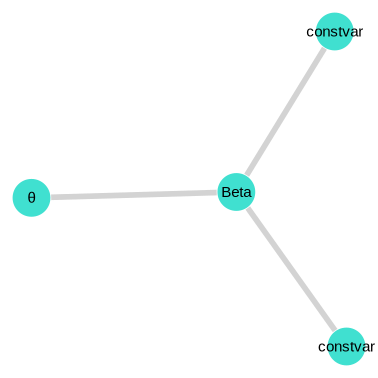

In [52]:

jl.seval("data_for_x = [ 1.0, 0.0, 0.0, 1.0 ]")
jl.seval("model = GraphPPL.create_model(coin_toss())do model,context return(;x = GraphPPL.datalabel(model, context, GraphPPL.NodeCreationOptions(kind = GraphPPL.VariableKindData), :x, data_for_x))end")

#RxInfer.ReactiveMPGraphPPLBackend

jl.seval("using GraphPlot, Cairo")
jl.seval("GraphPlot.gplot(model)")
#



In [53]:
import flaxdiff

In [6]:
from julia import Julia
#jl = Julia(runtime="\\wsl.localhost\\Ubuntu\\root\\miniconda3\\envs\\rapids-23.04\\lib\\python3.10\\site-packages\\Julia")

In [ ]:
#GraphPPL.get_model(model)
#\\wsl.localhost\Ubuntu\root\miniconda3\envs\rapids-23.04\lib\python3.10\site-packages\Julia

In [9]:
class emodel(nn.Module):    # homogenous agent for parameters sharing, assumes all agents have same obs and action dim
    action_dim: int
    hidden_dim: int
    init_scale: float

    @nn.compact
    def __call__(self, hidden, x):
        guide = ESM()# marginal_guide = posterior predictive entropy d can also be expressed as pi 
        numpyro.clear_param_store()
        # To reduce noise when comparing designs, we will use the precomputed value of H(p(w))
        # By passing eig=False, we tell Pyro not to estimate the prior entropy on each run
        # The return value of `posterior_eig` is then -E_p(w,y)[log q(w|y)] where w = x
        """
        def model(polling_allocation):
            # This allows us to run many copies of the model in parallel
            with numpyro.plate_stack("plate_stack", polling_allocation.shape[:-1]):
                # We use a Normal prior for theta
                #p
                theta = numpyro.sample("theta", dist.Normal(torch.tensor(0.0), torch.tensor(2.0)))
                design = polling_allocation
                # We use a simple logistic regression model for the likelihood
                #we need to replace this with some kind of function that represents whether the cartpole will fall given action 
                #the gravity parameter will be one of the unknown parameters whose selection in addition to action we will be optimzing for
                logit_p = theta - design
                # Now compute w according to the (approximate) electoral college formula
                #dem_win = election_winner(alpha)#where alpha is the hidden variable with the prior. It is essentially like theta
                y = numpyro.sample("y", dist.Bernoulli(logits=logit_p))

                return y
        """

        def model(polling_allocation):
            # This allows us to run many copies of the model in parallel
            with numpyro.plate_stack("plate_stack", polling_allocation.shape[:-1]):
                # Begin by sampling alpha
                alpha = numpyro.sample("alpha", dist.MultivariateNormal(
                    prior_mean, covariance_matrix=prior_covariance))

                # Sample y conditional on alpha
                poll_results = numpyro.sample("y", dist.Binomial(
                    polling_allocation, logits=alpha).to_event(1))
                """
                # Now compute w according to the (approximate) electoral college formula
                dem_win = win_condition(alpha)

                #now compute win condition for cartpole
                dem_win = 0

                numpyro.sample("w", dist.Delta(dem_win))

                return poll_results, dem_win, alpha
        #ape = average posterior entropy
        #allocation here means experiment design
        #we dont need to wory about sample size or optimizer since here we are optimizing over psuedo observations
        ape = posterior_eig(model, allocation, "y", "theta", 10, 12500, guide,
                        Adam({"lr": 0.001}), eig=False, final_num_samples=10000)
        """
        eigs[strategy] = prior_entropy - ape
        print(eigs[strategy].item())

        if eigs[strategy] > best_eig:
            best_strategy, best_eig = strategy, eigs[strategy]
        """

        EFE + obs -> RNN -> IQValue +h

        for now we should have this IQvalue equal ape/n and see what happens. 

        emodels and bmodels are going to both be substituted for the mixer networks for selection and evaluation

        meanwhile we will have a single agent network whose job will be to take the obs and the q_tot and turn it into individual q values.

        observation space for bmodels and emodels will just be cartpole

        observation space for individual agents will be: all agents during training, some agents during execution

        so ultimately we will have emodels and bmodels generate the q_tot
        
        
        self.fc1 = nn.Linear(self.obs_size, self.rnn_hidden_dim)
        self.rnn = nn.GRUCell(self.rnn_hidden_dim, self.rnn_hidden_dim)
        
        self.fc2 = nn.Linear(self.rnn_hidden_dim, num_outputs)
        self.n_agents = model_config["n_agents"]
        """
    def get_initial_state(self):

        return [
            self.fc1.weight.new(self.n_agents, self.rnn_hidden_dim).zero_().squeeze(0)
        ]

    def forward(self,x,input_dict, hidden_state, seq_lens):

        #negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
                # Place hidden states on same device as model.
        
        aspace=[0,1,2]
        #the below will probably need to go into the main algorithm training loop
        for strategy, allocation in aspace:#replace poll strategies with action space 
            guide = OutcomePredictor()
            numpyro.clear_param_store()
            # To reduce noise when comparing designs, we will use the precomputed value of H(p(w))
            # By passing eig=False, we tell Pyro not to estimate the prior entropy on each run
            # The return value of `posterior_eig` is then -E_p(w,y)[log q(w|y)]
            y = input_dict["obs_flat"].float()
            ape = posterior_eig(model, allocation, "y", "w", 10, 12500, guide,
                                Adam({"lr": 0.001}), eig=False, final_num_samples=10000)
            eigs[strategy] = -ape
            print(eigs[strategy].item())
            if eigs[strategy] > best_eig:
                best_strategy, best_eig = strategy, eigs[strategy]
        
        #####################################################################################
        """
        x = nn.functional.relu(self.fc1(input_dict["obs_flat"].float()))


        """
        h_in = hidden_state[0].reshape(-1, self.rnn_hidden_dim)
        h = self.rnn(x, h_in)   
        q=0
        return q, [h]

In [2]:
import torch
import torch.utils.data as data

In [ ]:
from torch2jax import j2t, t2j

In [8]:
class bmodel(nn.Module):
    action_dim: int
    hidden_dim: int
    init_scale: float

    @nn.compact
    def __call__(self, hidden, x):

        """
        VFE = ELBO

        we may need to call emodels within bmodels to furnish the prior
        
        
        input: obs and q_tots
        output: individual q values

        """

        flow = zuko.flows.NSF(features=2, transforms=3, hidden_features=(64, 64))
        print(flow)
        x = jnp.ones(30)
        j2t(x)
        trainset = data.TensorDataset(x)
        trainloader = data.DataLoader(trainset, batch_size=64, shuffle=True)
        optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
        """
        for epoch in range(8):
            losses = []

            for x, label in trainloader:
                loss = -flow().log_prob(x).mean()
                loss.backward()

                optimizer.step()
                optimizer.zero_grad()

                losses.append(loss.detach())

            losses = torch.stack(losses)

        
        #alternatively we can use this

        import torch

        trainer = Trainer(
            model=flow,
            train_dataloader=train_dataloader,
            eval_dataloader=eval_dataloader,
            optimizers=torch.optim.Adam(lr=0.01),
            max_duration=10,  # epochs
            device='gpu'
        )
        #where trainer is simply our mosaiclml trainer. Our other solution would be to try to compile the model into jax
        trainer.fit()
                
        samples = flow().sample((1,))



        """
        obs, dones = x
        embedding = nn.Dense(self.hidden_dim, kernel_init=orthogonal(self.init_scale), bias_init=constant(0.0))(obs)
        embedding = nn.relu(embedding)

        rnn_in = (embedding, dones)
        hidden, embedding = ScannedRNN()(hidden, rnn_in)
        q_vals = nn.Dense(self.action_dim, kernel_init=orthogonal(self.init_scale), bias_init=constant(0.0))(embedding)
        
        return hidden, q_vals

In [ ]:
#example of ivy

import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

input_array = tf.random.normal((1, 28, 28, 3))
torch_model =  ivy.transpile(model, source="torch", to="jax")#ivy.transpile(model, to="torch", args=(input_array,))

In [ ]:
class HyperNetwork(nn.Module):
    """HyperNetwork for generating weights of QMix' mixing network."""
    hidden_dim: int
    output_dim: int
    init_scale: float

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.hidden_dim, kernel_init=orthogonal(self.init_scale), bias_init=constant(0.))(x)
        x = nn.relu(x)
        x = nn.Dense(self.output_dim, kernel_init=orthogonal(self.init_scale), bias_init=constant(0.))(x)
        return x

In [ ]:
#this module is slated for deletion and replacement with bmodels and emodels.

class MixingNetwork(nn.Module):
    """
    Mixing network for projecting individual agent Q-values into Q_tot. Follows the original QMix implementation.
    """
    embedding_dim: int
    hypernet_hidden_dim: int
    init_scale: float

    @nn.compact
    def __call__(self, q_vals, states):
        
        n_agents, time_steps, batch_size = q_vals.shape
        q_vals = jnp.transpose(q_vals, (1, 2, 0)) # (time_steps, batch_size, n_agents)
        
        # hypernetwork
        w_1 = HyperNetwork(hidden_dim=self.hypernet_hidden_dim, output_dim=self.embedding_dim*n_agents, init_scale=self.init_scale)(states)
        b_1 = nn.Dense(self.embedding_dim, kernel_init=orthogonal(self.init_scale), bias_init=constant(0.))(states)
        w_2 = HyperNetwork(hidden_dim=self.hypernet_hidden_dim, output_dim=self.embedding_dim, init_scale=self.init_scale)(states)
        b_2 = HyperNetwork(hidden_dim=self.embedding_dim, output_dim=1, init_scale=self.init_scale)(states)
        
        # monotonicity and reshaping
        w_1 = jnp.abs(w_1.reshape(time_steps, batch_size, n_agents, self.embedding_dim))
        b_1 = b_1.reshape(time_steps, batch_size, 1, self.embedding_dim)
        w_2 = jnp.abs(w_2.reshape(time_steps, batch_size, self.embedding_dim, 1))
        b_2 = b_2.reshape(time_steps, batch_size, 1, 1)
    
        # mix
        hidden = nn.elu(jnp.matmul(q_vals[:, :, None, :], w_1) + b_1)
        q_tot  = jnp.matmul(hidden, w_2) + b_2
        
        return q_tot.squeeze() # (time_steps, batch_size)

In [ ]:

class EpsilonGreedy:
    """Epsilon Greedy action selection"""

    def __init__(self, start_e: float, end_e: float, duration: int):
        self.start_e  = start_e
        self.end_e    = end_e
        self.duration = duration
        self.slope    = (end_e - start_e) / duration
        
    @partial(jax.jit, static_argnums=0)
    def get_epsilon(self, t: int):
        e = self.slope*t + self.start_e
        return jnp.clip(e, self.end_e)
    
    @partial(jax.jit, static_argnums=0)
    def choose_actions(self, q_vals: dict, t: int, rng: chex.PRNGKey):
        
        def explore(q, eps, key):
            key_a, key_e   = jax.random.split(key, 2) # a key for sampling random actions and one for picking
            greedy_actions = jnp.argmax(q, axis=-1) # get the greedy actions 
            random_actions = jax.random.randint(key_a, shape=greedy_actions.shape, minval=0, maxval=q.shape[-1]) # sample random actions
            pick_random    = jax.random.uniform(key_e, greedy_actions.shape)<eps # pick which actions should be random
            chosed_actions = jnp.where(pick_random, random_actions, greedy_actions)
            return chosed_actions
        
        eps = self.get_epsilon(t)
        keys = dict(zip(q_vals.keys(), jax.random.split(rng, len(q_vals)))) # get a key for each agent
        chosen_actions = jax.tree_map(lambda q, k: explore(q, eps, k), q_vals, keys)
        return chosen_actions

In [ ]:
class Transition(NamedTuple):
    obs: dict
    actions: dict
    rewards: dict
    dones: dict
    infos: dict


def make_train(config, env):

    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )

    
    def train(rng):

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        wrapped_env = CTRolloutManager(env, batch_size=config["NUM_ENVS"])
        test_env = CTRolloutManager(env, batch_size=config["NUM_TEST_EPISODES"]) # batched env for testing (has different batch size)
        init_obs, env_state = wrapped_env.batch_reset(_rng)
        init_dones = {agent:jnp.zeros((config["NUM_ENVS"]), dtype=bool) for agent in env.agents+['__all__']}

        # INIT BUFFER
        # to initalize the buffer is necessary to sample a trajectory to know its strucutre
        def _env_sample_step(env_state, unused):
            rng, key_a, key_s = jax.random.split(jax.random.PRNGKey(0), 3) # use a dummy rng here
            key_a = jax.random.split(key_a, env.num_agents)
            actions = {agent: wrapped_env.batch_sample(key_a[i], agent) for i, agent in enumerate(env.agents)}
            obs, env_state, rewards, dones, infos = wrapped_env.batch_step(key_s, env_state, actions)
            transition = Transition(obs, actions, rewards, dones, infos)
            return env_state, transition
        _, sample_traj = jax.lax.scan(
            _env_sample_step, env_state, None, config["NUM_STEPS"]
        )
        sample_traj_unbatched = jax.tree_map(lambda x: x[:, 0], sample_traj) # remove the NUM_ENV dim
        buffer = fbx.make_trajectory_buffer(
            max_length_time_axis=config['BUFFER_SIZE']//config['NUM_ENVS'],
            min_length_time_axis=config['BUFFER_BATCH_SIZE'],
            sample_batch_size=config['BUFFER_BATCH_SIZE'],
            add_batch_size=config['NUM_ENVS'],
            sample_sequence_length=1,
            period=1,
        )
        buffer_state = buffer.init(sample_traj_unbatched) 

        # INIT NETWORK
        # init agent
        agent = AgentRNN(action_dim=wrapped_env.max_action_space, hidden_dim=config["AGENT_HIDDEN_DIM"], init_scale=config['AGENT_INIT_SCALE'])
        rng, _rng = jax.random.split(rng)
        if config["PARAMETERS_SHARING"]:
            init_x = (
                jnp.zeros((1, 1, wrapped_env.obs_size)), # (time_step, batch_size, obs_size)
                jnp.zeros((1, 1)) # (time_step, batch size)
            )
            init_hs = ScannedRNN.initialize_carry(config['AGENT_HIDDEN_DIM'], 1) # (batch_size, hidden_dim)
            agent_params = agent.init(_rng, init_hs, init_x)
        else:
            init_x = (
                jnp.zeros((len(env.agents), 1, 1, wrapped_env.obs_size)), # (time_step, batch_size, obs_size)
                jnp.zeros((len(env.agents), 1, 1)) # (time_step, batch size)
            )
            init_hs = ScannedRNN.initialize_carry(config['AGENT_HIDDEN_DIM'], len(env.agents),  1) # (n_agents, batch_size, hidden_dim)
            rngs = jax.random.split(_rng, len(env.agents)) # a random init for each agent
            agent_params = jax.vmap(agent.init, in_axes=(0, 0, 0))(rngs, init_hs, init_x)

        # init mixer
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros((len(env.agents), 1, 1))
        state_size = sample_traj.obs['__all__'].shape[-1]  # get the state shape from the buffer
        init_state = jnp.zeros((1, 1, state_size))
        mixer = MixingNetwork(config['MIXER_EMBEDDING_DIM'], config["MIXER_HYPERNET_HIDDEN_DIM"], config['MIXER_INIT_SCALE'])
        mixer_params = mixer.init(_rng, init_x, init_state)

        # init optimizer
        network_params = frozen_dict.freeze({'agent':agent_params, 'mixer':mixer_params})
        def linear_schedule(count):
            frac = 1.0 - (count / config["NUM_UPDATES"])
            return config["LR"] * frac
        lr = linear_schedule if config.get('LR_LINEAR_DECAY', False) else config['LR']
        tx = optax.chain(
            optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
            optax.adamw(learning_rate=lr, eps=config['EPS_ADAM'], weight_decay=config['WEIGHT_DECAY_ADAM']),#replace with prodigy
        )
        train_state = TrainState.create(
            apply_fn=None,
            params=network_params,
            tx=tx,
        )
        # target network params
        target_network_params = jax.tree_map(lambda x: jnp.copy(x), train_state.params)
        
        # INIT EXPLORATION STRATEGY
        explorer = EpsilonGreedy(
            start_e=config["EPSILON_START"],
            end_e=config["EPSILON_FINISH"],
            duration=config["EPSILON_ANNEAL_TIME"]
        )

        # depending if using parameters sharing or not, q-values are computed using one or multiple parameters
        if config["PARAMETERS_SHARING"]:
            def homogeneous_pass(params, hidden_state, obs, dones):
                # concatenate agents and parallel envs to process them in one batch
                agents, flatten_agents_obs = zip(*obs.items())
                original_shape = flatten_agents_obs[0].shape # assumes obs shape is the same for all agents
                batched_input = (
                    jnp.concatenate(flatten_agents_obs, axis=1), # (time_step, n_agents*n_envs, obs_size)
                    jnp.concatenate([dones[agent] for agent in agents], axis=1), # ensure to not pass other keys (like __all__)
                )
                hidden_state, q_vals = agent.apply(params, hidden_state, batched_input)
                q_vals = q_vals.reshape(original_shape[0], len(agents), *original_shape[1:-1], -1) # (time_steps, n_agents, n_envs, action_dim)
                q_vals = {a:q_vals[:,i] for i,a in enumerate(agents)}
                return hidden_state, q_vals
        else:
            def homogeneous_pass(params, hidden_state, obs, dones):
                # homogeneous pass vmapped in respect to the agents parameters (i.e., no parameter sharing)
                agents, flatten_agents_obs = zip(*obs.items())
                batched_input = (
                    jnp.stack(flatten_agents_obs, axis=0), # (n_agents, time_step, n_envs, obs_size)
                    jnp.stack([dones[agent] for agent in agents], axis=0), # ensure to not pass other keys (like __all__)
                )
                # computes the q_vals with the params of each agent separately by vmapping
                hidden_state, q_vals = jax.vmap(agent.apply, in_axes=0)(params, hidden_state, batched_input)
                q_vals = {a:q_vals[i] for i,a in enumerate(agents)}
                return hidden_state, q_vals


        # TRAINING LOOP
        def _update_step(runner_state, unused):

            train_state, target_network_params, env_state, buffer_state, time_state, init_obs, init_dones, test_metrics, rng = runner_state

            # EPISODE STEP
            def _env_step(step_state, unused):

                params, env_state, last_obs, last_dones, hstate, rng, t = step_state

                # prepare rngs for actions and step
                rng, key_a, key_s = jax.random.split(rng, 3)

                # SELECT ACTION
                # add a dummy time_step dimension to the agent input
                obs_   = {a:last_obs[a] for a in env.agents} # ensure to not pass the global state (obs["__all__"]) to the network
                obs_   = jax.tree_map(lambda x: x[jnp.newaxis, :], obs_)
                dones_ = jax.tree_map(lambda x: x[jnp.newaxis, :], last_dones)
                # get the q_values from the agent network
                hstate, q_vals = homogeneous_pass(params, hstate, obs_, dones_)#add in q_tot 
                # remove the dummy time_step dimension and index qs by the valid actions of each agent 
                valid_q_vals = jax.tree_util.tree_map(lambda q, valid_idx: q.squeeze(0)[..., valid_idx], q_vals, wrapped_env.valid_actions)
                # explore with epsilon greedy_exploration
                actions = explorer.choose_actions(valid_q_vals, t, key_a)# 

                # STEP ENV
                obs, env_state, rewards, dones, infos = wrapped_env.batch_step(key_s, env_state, actions)
                transition = Transition(last_obs, actions, rewards, dones, infos)

                step_state = (params, env_state, obs, dones, hstate, rng, t+1)
                return step_state, transition


            # prepare the step state and collect the episode trajectory
            rng, _rng = jax.random.split(rng)
            if config["PARAMETERS_SHARING"]:
                hstate = ScannedRNN.initialize_carry(config['AGENT_HIDDEN_DIM'], len(env.agents)*config["NUM_ENVS"]) # (n_agents*n_envs, hs_size)
            else:
                hstate = ScannedRNN.initialize_carry(config['AGENT_HIDDEN_DIM'], len(env.agents), config["NUM_ENVS"]) # (n_agents, n_envs, hs_size)

            step_state = (
                train_state.params['agent'],
                env_state,
                init_obs,
                init_dones,
                hstate, 
                _rng,
                time_state['timesteps'] # t is needed to compute epsilon
            )

            step_state, traj_batch = jax.lax.scan(
                _env_step, step_state, None, config["NUM_STEPS"]
            )

            # BUFFER UPDATE: save the collected trajectory in the buffer
            buffer_traj_batch = jax.tree_util.tree_map(
                lambda x:jnp.swapaxes(x, 0, 1)[:, jnp.newaxis], # put the batch dim first and add a dummy sequence dim
                traj_batch
            ) # (num_envs, 1, time_steps, ...)
            buffer_state = buffer.add(buffer_state, buffer_traj_batch)

            # LEARN PHASE
            def q_of_action(q, u):
                """index the q_values with action indices"""
                q_u = jnp.take_along_axis(q, jnp.expand_dims(u, axis=-1), axis=-1)
                return jnp.squeeze(q_u, axis=-1)

            def _loss_fn(params, target_network_params, init_hstate, learn_traj):

                obs_ = {a:learn_traj.obs[a] for a in env.agents} # ensure to not pass the global state (obs["__all__"]) to the network

                # compute q_tot with the mixer network.we are reversing the order so that q_tot is computed first
                chosen_action_qvals_mix = mixer.apply(
                    params['mixer'], 
                    jnp.stack(list(chosen_action_qvals.values())),
                    learn_traj.obs['__all__'][:-1] # avoid last timestep #cartpole obs 
                )
                target_max_qvals_mix = mixer.apply(#
                    target_network_params['mixer'], 
                    jnp.stack(list(target_max_qvals.values())),
                    learn_traj.obs['__all__'][1:] # avoid first timestep #this may need to be modified to just cartpole obs
                )

                _, q_vals = homogeneous_pass(params['agent'], init_hstate, obs_, learn_traj.dones)#add q_tot as an argument 
                _, target_q_vals = homogeneous_pass(target_network_params['agent'], init_hstate, obs_, learn_traj.dones)# add tq_tot as an arg


                """
                under the standard approach it is computing individual q values followed by mixer network qvalues

                we therefore have chosen to reverse the order 

                Before we proceed the following questions need to be asked:

                Under the standard assumptions the agents need to do RL with exploration in order to find best actions that 
                will then be used to generate a q_TOT. However no exploration under this standard implementation is done. Q_tot soley
                depends on qvalues that are generated through epsilon greedy and standard RL. Q_tot is simply a produced artifact
                from the neural network given the individual qvalues. 

                In our modification both Q_tots are already known. However given the Q_tot, and obs we still need the individual agents 
                to do standard RL to select and evaluate actions that will give back the Q_tot. Hence epsilon-greedy will remain

                bmodels -> first qtot; emodels -> second qtot;  Obs+ qtots+actions* -> "unmixer" network -> Individual q values

                *full during training partial during execution 

                unmixer network = scannedrnn -> agentrnn

                New arguments for agentrnn: Qtot, obs, other agent actions. 

                current arguments: obs, action space*

                Last major outstanding question: how do we allow each agent to have different policies?

                ANS: this implementation works with non-homogenous agents (different obs/action spaces). Also we can turn off parameter sharing. 

                for the moment this should be sufficient to create groups of different neuronal agents. 

                the preliminary groupings will be 1: excitatory pol1, 2: inhibitory pol1, 3: excitatory lowest 

                homogenous pass simply takes and transforms output of agent which in turn takes and transforms output of agentrnn

                second note we will eliminate the mixer network and simply apply a minmax scalar transformation to the output of emodels and bmodels. 

                third note: from the point of view of every given neuronal agent every other agent will be treated as existing in the env. However in practice most
                of the neuronal agents will only interact with one another and only the lowest level neuronal agents will get to interact with both the other neuronal agents and the env

                Do not implment fourth note for now
                fourth note: We need to limit the amount of domain knowledge we directly incorporate into our simulation so we can simulate the brain from first principles
                and in particular from the free energy principle. That being said one rule that we will tack on is from the principles of neural design book which talks about 
                the scaling of the amount of information and the distance the information is sent 

                we will therefore tack on a regularizer of some kind that will penalize each action taken by the neuronal agents as well as the distance the information is sent. 

                Final note: We most likely cannot use the trainers withen the emodels, bmodels etc. All of the trainers and such will need to go into this training loop
                """


                # get the q_vals of the taken actions (with exploration) for each agent
                chosen_action_qvals = jax.tree_map(
                    lambda q, u: q_of_action(q, u)[:-1], # avoid last timestep
                    q_vals,
                    learn_traj.actions
                )

                # get the target q value of the greedy actions for each agent
                valid_q_vals = jax.tree_util.tree_map(lambda q, valid_idx: q[..., valid_idx], q_vals, wrapped_env.valid_actions)
                target_max_qvals = jax.tree_map(
                    lambda t_q, q: q_of_action(t_q, jnp.argmax(q, axis=-1))[1:], # avoid first timestep
                    target_q_vals,
                    jax.lax.stop_gradient(valid_q_vals)
                )


                # compute target
                if config.get('TD_LAMBDA_LOSS', True):
                    # time difference loss
                    def _td_lambda_target(ret, values):
                        reward, done, target_qs = values
                        ret = jnp.where(
                            done,
                            target_qs,
                            ret*config['TD_LAMBDA']*config['GAMMA']
                            + reward
                            + (1-config['TD_LAMBDA'])*config['GAMMA']*(1-done)*target_qs
                        )
                        return ret, ret

                    ret = target_max_qvals_mix[-1] * (1-learn_traj.dones['__all__'][-1])
                    ret, td_targets = jax.lax.scan(
                        _td_lambda_target,
                        ret,
                        (learn_traj.rewards['__all__'][-2::-1], learn_traj.dones['__all__'][-2::-1], target_max_qvals_mix[-1::-1])
                    )
                    targets = td_targets[::-1]
                    loss = jnp.mean(0.5*((chosen_action_qvals_mix - jax.lax.stop_gradient(targets))**2))
                else:
                    # standard DQN loss
                    targets = (
                        learn_traj.rewards['__all__'][:-1]
                        + config['GAMMA']*(1-learn_traj.dones['__all__'][:-1])*target_max_qvals_mix
                    )
                    loss = jnp.mean((chosen_action_qvals_mix - jax.lax.stop_gradient(targets))**2)
                
                return loss


            # sample a batched trajectory from the buffer and set the time step dim in first axis
            rng, _rng = jax.random.split(rng)
            learn_traj = buffer.sample(buffer_state, _rng).experience # (batch_size, 1, max_time_steps, ...)
            learn_traj = jax.tree_map(
                lambda x: jnp.swapaxes(x[:, 0], 0, 1), # remove the dummy sequence dim (1) and swap batch and temporal dims
                learn_traj
            ) # (max_time_steps, batch_size, ...)
            if config["PARAMETERS_SHARING"]:
                init_hs = ScannedRNN.initialize_carry(config['AGENT_HIDDEN_DIM'], len(env.agents)*config["BUFFER_BATCH_SIZE"]) # (n_agents*batch_size, hs_size)
            else:
                init_hs = ScannedRNN.initialize_carry(config['AGENT_HIDDEN_DIM'], len(env.agents), config["BUFFER_BATCH_SIZE"]) # (n_agents, batch_size, hs_size)

            # compute loss and optimize grad
            grad_fn = jax.value_and_grad(_loss_fn, has_aux=False)
            loss, grads = grad_fn(train_state.params, target_network_params, init_hs, learn_traj)
            train_state = train_state.apply_gradients(grads=grads)


            # UPDATE THE VARIABLES AND RETURN
            # reset the environment
            rng, _rng = jax.random.split(rng)
            init_obs, env_state = wrapped_env.batch_reset(_rng)
            init_dones = {agent:jnp.zeros((config["NUM_ENVS"]), dtype=bool) for agent in env.agents+['__all__']}

            # update the states
            time_state['timesteps'] = step_state[-1]
            time_state['updates']   = time_state['updates'] + 1

            # update the target network if necessary
            target_network_params = jax.lax.cond(
                time_state['updates'] % config['TARGET_UPDATE_INTERVAL'] == 0,
                lambda _: jax.tree_map(lambda x: jnp.copy(x), train_state.params),
                lambda _: target_network_params,
                operand=None
            )

            # update the greedy rewards
            rng, _rng = jax.random.split(rng)
            test_metrics = jax.lax.cond(
                time_state['updates'] % (config["TEST_INTERVAL"] // config["NUM_STEPS"] // config["NUM_ENVS"]) == 0,
                lambda _: get_greedy_metrics(_rng, train_state.params['agent'], time_state),
                lambda _: test_metrics,
                operand=None
            )

            # update the returning metrics
            metrics = {
                'timesteps': time_state['timesteps']*config['NUM_ENVS'],
                'updates' : time_state['updates'],
                'loss': loss,
                'rewards': jax.tree_util.tree_map(lambda x: jnp.sum(x, axis=0).mean(), traj_batch.rewards),
                #'eps': explorer.get_epsilon(time_state['timesteps'])
            }
            metrics['test_metrics'] = test_metrics # add the test metrics dictionary

            if config.get('WANDB_ONLINE_REPORT', False):
                def callback(metrics, infos):
                    info_metrics = {
                        k:v[...,0][infos["returned_episode"][..., 0]].mean()
                        for k,v in infos.items() if k!="returned_episode"
                    }
                    wandb.log(
                        {
                            "returns": metrics['rewards']['__all__'].mean(),
                            "timestep": metrics['timesteps'],
                            "updates": metrics['updates'],
                            "loss": metrics['loss'],
                            'epsilon': metrics['eps'],
                            **info_metrics,
                            **{k:v.mean() for k, v in metrics['test_metrics'].items()}
                        }
                    )
                jax.debug.callback(callback, metrics, traj_batch.infos)

            runner_state = (
                train_state,
                target_network_params,
                env_state,
                buffer_state,
                time_state,
                init_obs,
                init_dones,
                test_metrics,
                rng
            )

            return runner_state, metrics

        def get_greedy_metrics(rng, params, time_state):
            """Help function to test greedy policy during training"""
            def _greedy_env_step(step_state, unused):
                params, env_state, last_obs, last_dones, hstate, rng = step_state
                rng, key_s = jax.random.split(rng)
                obs_   = {a:last_obs[a] for a in env.agents}
                obs_   = jax.tree_map(lambda x: x[jnp.newaxis, :], obs_)
                dones_ = jax.tree_map(lambda x: x[jnp.newaxis, :], last_dones)
                hstate, q_vals = homogeneous_pass(params, hstate, obs_, dones_)
                actions = jax.tree_util.tree_map(lambda q, valid_idx: jnp.argmax(q.squeeze(0)[..., valid_idx], axis=-1), q_vals, test_env.valid_actions)
                obs, env_state, rewards, dones, infos = test_env.batch_step(key_s, env_state, actions)
                step_state = (params, env_state, obs, dones, hstate, rng)
                return step_state, (rewards, dones, infos)
            rng, _rng = jax.random.split(rng)
            init_obs, env_state = test_env.batch_reset(_rng)
            init_dones = {agent:jnp.zeros((config["NUM_TEST_EPISODES"]), dtype=bool) for agent in env.agents+['__all__']}
            rng, _rng = jax.random.split(rng)
            if config["PARAMETERS_SHARING"]:
                hstate = ScannedRNN.initialize_carry(config['AGENT_HIDDEN_DIM'], len(env.agents)*config["NUM_TEST_EPISODES"]) # (n_agents*n_envs, hs_size)
            else:
                hstate = ScannedRNN.initialize_carry(config['AGENT_HIDDEN_DIM'], len(env.agents), config["NUM_TEST_EPISODES"]) # (n_agents, n_envs, hs_size)
            step_state = (
                params,
                env_state,
                init_obs,
                init_dones,
                hstate, 
                _rng,
            )
            step_state, (rewards, dones, infos) = jax.lax.scan(
                _greedy_env_step, step_state, None, config["NUM_STEPS"]
            )
            # compute the metrics of the first episode that is done for each parallel env
            def first_episode_returns(rewards, dones):
                first_done = jax.lax.select(jnp.argmax(dones)==0., dones.size, jnp.argmax(dones))
                first_episode_mask = jnp.where(jnp.arange(dones.size) <= first_done, True, False)
                return jnp.where(first_episode_mask, rewards, 0.).sum()
            all_dones = dones['__all__']
            first_returns = jax.tree_map(lambda r: jax.vmap(first_episode_returns, in_axes=1)(r, all_dones), rewards)
            first_infos   = jax.tree_map(lambda i: jax.vmap(first_episode_returns, in_axes=1)(i[..., 0], all_dones), infos)
            metrics = {
                'test_returns': first_returns['__all__'],# episode returns
                **{'test_'+k:v for k,v in first_infos.items()}
            }
            if config.get('VERBOSE', False):
                def callback(timestep, val):
                    print(f"Timestep: {timestep}, return: {val}")
                jax.debug.callback(callback, time_state['timesteps']*config['NUM_ENVS'], first_returns['__all__'].mean())
            return metrics
        
        time_state = {
            'timesteps':jnp.array(0),
            'updates':  jnp.array(0)
        }
        rng, _rng = jax.random.split(rng)
        test_metrics = get_greedy_metrics(_rng, train_state.params['agent'],time_state) # initial greedy metrics

        # train
        rng, _rng = jax.random.split(rng)
        runner_state = (
            train_state,
            target_network_params,
            env_state,
            buffer_state,
            time_state,
            init_obs,
            init_dones,
            test_metrics,
            _rng
        )
        runner_state, metrics = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {'runner_state':runner_state, 'metrics':metrics}
    
    return train

In [ ]:
#modified env with cartpole and agent goes here 

import chex
from flax import struct
import jax
from jax import lax
import jax.numpy as jnp
from gymnax.environments import environment
from gymnax.environments import spaces


@struct.dataclass
class EnvState(environment.EnvState):
    x: jnp.ndarray
    x_dot: jnp.ndarray
    theta: jnp.ndarray
    theta_dot: jnp.ndarray
    time: int


@struct.dataclass
class EnvParams(environment.EnvParams):
    gravity: float = 9.8
    masscart: float = 1.0
    masspole: float = 0.1
    total_mass: float = 1.0 + 0.1  # (masscart + masspole)
    length: float = 0.5
    polemass_length: float = 0.05  # (masspole * length)
    force_mag: float = 10.0
    tau: float = 0.02
    theta_threshold_radians: float = 12 * 2 * jnp.pi / 360
    x_threshold: float = 2.4
    max_steps_in_episode: int = 500  # v0 had only 200 steps!


class CartPole(environment.Environment[EnvState, EnvParams]):
    """JAX Compatible version of CartPole-v1 OpenAI gym environment.


    Source: github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
    """

    def __init__(self):
        super().__init__()
        self.obs_shape = (4,)

    @property
    def default_params(self) -> EnvParams:
        # Default environment parameters for CartPole-v1
        return EnvParams()

    def step_env(
        self,
        key: chex.PRNGKey,
        state: EnvState,
        action: Union[int, float, chex.Array],
        params: EnvParams,
    ) -> Tuple[chex.Array, EnvState, jnp.ndarray, jnp.ndarray, Dict[Any, Any]]:
        """Performs step transitions in the environment."""
        prev_terminal = self.is_terminal(state, params)
        force = params.force_mag * action - params.force_mag * (1 - action)
        costheta = jnp.cos(state.theta)
        sintheta = jnp.sin(state.theta)

        temp = (
            force + params.polemass_length * state.theta_dot**2 * sintheta
        ) / params.total_mass
        thetaacc = (params.gravity * sintheta - costheta * temp) / (
            params.length
            * (4.0 / 3.0 - params.masspole * costheta**2 / params.total_mass)
        )
        xacc = temp - params.polemass_length * thetaacc * costheta / params.total_mass

        # Only default Euler integration option available here!
        x = state.x + params.tau * state.x_dot
        x_dot = state.x_dot + params.tau * xacc
        theta = state.theta + params.tau * state.theta_dot
        theta_dot = state.theta_dot + params.tau * thetaacc

        # Important: Reward is based on termination is previous step transition
        reward = 1.0 - prev_terminal

        # Update state dict and evaluate termination conditions
        state = EnvState(
            x=x,
            x_dot=x_dot,
            theta=theta,
            theta_dot=theta_dot,
            time=state.time + 1,
        )
        done = self.is_terminal(state, params)

        return (
            lax.stop_gradient(self.get_obs(state)),
            lax.stop_gradient(state),
            jnp.array(reward),
            done,
            {"discount": self.discount(state, params)},
        )

    def reset_env(
        self, key: chex.PRNGKey, params: EnvParams
    ) -> Tuple[chex.Array, EnvState]:
        """Performs resetting of environment."""
        init_state = jax.random.uniform(key, minval=-0.05, maxval=0.05, shape=(4,))
        state = EnvState(
            x=init_state[0],
            x_dot=init_state[1],
            theta=init_state[2],
            theta_dot=init_state[3],
            time=0,
        )
        return self.get_obs(state), state

    def get_obs(self, state: EnvState, params=None, key=None) -> chex.Array:
        """Applies observation function to state."""
        return jnp.array([state.x, state.x_dot, state.theta, state.theta_dot])

    def is_terminal(self, state: EnvState, params: EnvParams) -> jnp.ndarray:
        """Check whether state is terminal."""
        # Check termination criteria
        done1 = jnp.logical_or(
            state.x < -params.x_threshold,
            state.x > params.x_threshold,
        )
        done2 = jnp.logical_or(
            state.theta < -params.theta_threshold_radians,
            state.theta > params.theta_threshold_radians,
        )

        # Check number of steps in episode termination condition
        done_steps = state.time >= params.max_steps_in_episode
        done = jnp.logical_or(jnp.logical_or(done1, done2), done_steps)
        return done

    @property
    def name(self) -> str:
        """Environment name."""
        return "CartPole-v1"

    @property
    def num_actions(self) -> int:
        """Number of actions possible in environment."""
        return 2

    def action_space(self, params: Optional[EnvParams] = None) -> spaces.Discrete:
        """Action space of the environment."""
        return spaces.Discrete(2)

    def observation_space(self, params: EnvParams) -> spaces.Box:
        """Observation space of the environment."""
        high = jnp.array(
            [
                params.x_threshold * 2,
                jnp.finfo(jnp.float32).max,
                params.theta_threshold_radians * 2,
                jnp.finfo(jnp.float32).max,
            ]
        )
        return spaces.Box(-high, high, (4,), dtype=jnp.float32)

    def state_space(self, params: EnvParams) -> spaces.Dict:
        """State space of the environment."""
        high = jnp.array(
            [
                params.x_threshold * 2,
                jnp.finfo(jnp.float32).max,
                params.theta_threshold_radians * 2,
                jnp.finfo(jnp.float32).max,
            ]
        )
        return spaces.Dict(
            {
                "x": spaces.Box(-high[0], high[0], (), jnp.float32),
                "x_dot": spaces.Box(-high[1], high[1], (), jnp.float32),
                "theta": spaces.Box(-high[2], high[2], (), jnp.float32),
                "theta_dot": spaces.Box(-high[3], high[3], (), jnp.float32),
                "time": spaces.Discrete(params.max_steps_in_episode),
            }
        )



In [ ]:
#modify later 
config = {
    "NUM_ENVS": 8,
    "NUM_STEPS": 128,
    "BUFFER_SIZE": 3000,
    "BUFFER_BATCH_SIZE": 32,
    "TOTAL_TIMESTEPS": 20000000,
    "AGENT_HIDDEN_DIM": 256,
    "AGENT_INIT_SCALE": 1.,
    "PARAMETERS_SHARING": True,
    "EPSILON_START": 1.0,
    "EPSILON_FINISH": 0.05,
    "EPSILON_ANNEAL_TIME": 100000,
    "MIXER_EMBEDDING_DIM": 64,
    "MIXER_HYPERNET_HIDDEN_DIM": 256,
    "MIXER_INIT_SCALE": 0.001,
    "MAX_GRAD_NORM": 10,
    "TARGET_UPDATE_INTERVAL": 200,
    #"LR": 0.001
    #"LR_LINEAR_DECAY": False #the primary optmizer will not use a learning rate
    #"EPS_ADAM": 0.00001
    #"WEIGHT_DECAY_ADAM": 0.000001
    "TD_LAMBDA_LOSS": False,
    "TD_LAMBDA": 0.6,
    "GAMMA": 0.99,
    "VERBOSE": False,
    "WANDB_ONLINE_REPORT": True,
    "NUM_TEST_EPISODES": 32,
    "TEST_INTERVAL": 100000
}

In [ ]:
@hydra.main(version_base=None, config_path="./config", config_name="config")
def main(config):
    config = OmegaConf.to_container(config)

    print('Config:\n', OmegaConf.to_yaml(config))

    env_name = config["env"]["ENV_NAME"]
    alg_name = f'qmix_{"ps" if config["alg"].get("PARAMETERS_SHARING", True) else "ns"}'

    env = make(config["env"]["ENV_NAME"], **config['env']['ENV_KWARGS'])
    env = LogWrapper(env)

    
    # smac init neeeds a scenario
    """
    if 'smax' in env_name.lower():
        config['env']['ENV_KWARGS']['scenario'] = map_name_to_scenario(config['env']['MAP_NAME'])
        env_name = f"{config['env']['ENV_NAME']}_{config['env']['MAP_NAME']}"
        env = make(config["env"]["ENV_NAME"], **config['env']['ENV_KWARGS'])
        env = SMAXLogWrapper(env)
    else:
        env = make(config["env"]["ENV_NAME"], **config['env']['ENV_KWARGS'])
        env = LogWrapper(env)

    config["alg"]["NUM_STEPS"] = config["alg"].get("NUM_STEPS", env.max_steps) # default steps defined by the env
    """

    """
    we also need to implement a sherpa-parameter hyperparameter optimization with population based search and eliminate wanb.
    
    
    """
    
    wandb.init(
        entity=config["ENTITY"],
        project=config["PROJECT"],
        tags=[
            alg_name.upper(),
            env_name.upper(),
            "RNN",
            "TD_LOSS" if config["alg"].get("TD_LAMBDA_LOSS", True) else "DQN_LOSS",
            f"jax_{jax.__version__}",
        ],
        name=f'{alg_name}_{env_name}',
        config=config,
        mode=config["WANDB_MODE"],
    )
    
    rng = jax.random.PRNGKey(config["SEED"])
    rngs = jax.random.split(rng, config["NUM_SEEDS"])
    train_vjit = jax.jit(jax.vmap(make_train(config["alg"], env)))
    outs = jax.block_until_ready(train_vjit(rngs))
    
    # save params
    if config['SAVE_PATH'] is not None:

        def save_params(params: Dict, filename: Union[str, os.PathLike]) -> None:
            flattened_dict = flatten_dict(params, sep=',')
            save_file(flattened_dict, filename)

        model_state = outs['runner_state'][0]
        params = jax.tree_map(lambda x: x[0], model_state.params) # save only params of the firt run
        save_dir = os.path.join(config['SAVE_PATH'], env_name)
        os.makedirs(save_dir, exist_ok=True)
        save_params(params, f'{save_dir}/{alg_name}.safetensors')
        print(f'Parameters of first batch saved in {save_dir}/{alg_name}.safetensors')


if __name__ == "__main__":
    main()

Below is the def _loss_fn from the jaxmarl qmix from the class make_train. We have to fogure out how to get the losses of swap out agent and target networks for bmodels and emodels

also in pegasus we do not use epsilon greedy or any other explorer because it is automatically handled by bmodels and optimization of expected free energy. we will have to figure out how to modify
the jaxmarl implementation and remove the epsiolon greedy explorer 

In [ ]:


"""
            def _loss_fn(params, target_network_params, init_hstate, learn_traj):

                obs_ = {a:learn_traj.obs[a] for a in env.agents} # ensure to not pass the global state (obs["__all__"]) to the network
                _, q_vals = homogeneous_pass(params['agent'], init_hstate, obs_, learn_traj.dones)
                _, target_q_vals = homogeneous_pass(target_network_params['agent'], init_hstate, obs_, learn_traj.dones)

                # get the q_vals of the taken actions (with exploration) for each agent
                chosen_action_qvals = jax.tree_map(
                    lambda q, u: q_of_action(q, u)[:-1], # avoid last timestep
                    q_vals,
                    learn_traj.actions
                )

                # get the target q value of the greedy actions for each agent
                valid_q_vals = jax.tree_util.tree_map(lambda q, valid_idx: q[..., valid_idx], q_vals, wrapped_env.valid_actions)
                target_max_qvals = jax.tree_map(
                    lambda t_q, q: q_of_action(t_q, jnp.argmax(q, axis=-1))[1:], # avoid first timestep
                    target_q_vals,
                    jax.lax.stop_gradient(valid_q_vals)
                )

                # compute q_tot with the mixer network
                chosen_action_qvals_mix = mixer.apply(
                    params['mixer'], 
                    jnp.stack(list(chosen_action_qvals.values())),
                    learn_traj.obs['__all__'][:-1] # avoid last timestep
                )
                target_max_qvals_mix = mixer.apply(
                    target_network_params['mixer'], 
                    jnp.stack(list(target_max_qvals.values())),
                    learn_traj.obs['__all__'][1:] # avoid first timestep
                )
"""

reinforcement learning is computationally very intensive. We are therefore going to carry out a partial simulation with a smaller number of agents and then use maximum entropy maximization to infer the behavior of the rest of the agents. 

we can use another aspect of max entropy to test various hypotheses and yet another aspect to detect motifs or patterns in the simulation

This will be implemented in phase 2 when we increase the definition of our simulation

each resolution level will have a small number of rl agents. We will then use max entropy to infer the full graph strucutre including the other neuronal agents, their actions and the 
which agents recieve the sent action potentials 

question: is it possible to infer the optimal number of agents needed to infer the full graph structure?

this will be particulary useful in downscaling: creating agents in finer and smaller resolutions 

one of the constraints we can impose is one of self-similarity

In [ ]:
import numpy as np
import networkx as nx
from NEMtropy import UndirectedGraph, matrix_generator
from NEMtropy.network_functions import build_adjacency_from_edgelist

import networkx as nx
from NEMtropy import UndirectedGraph

G = nx.karate_club_graph()
adj_kar = nx.to_numpy_array(G)
graph = UndirectedGraph(adj_kar)

#generating null models
graph.solve_tool(model="cm_exp",
                 method="fixed_point",
                 initial_guess="random")

# After that we have solved the model we can use it to generate random versions of zachary karate club.
# The ensemble sampler function generates "n" random versions of zachary karate club using the model parameters computed by solve_tool.

graph.ensemble_sampler(10, cpu_n=12, output_dir="sample/")

In [ ]:
###########################

#policy proposer algorithm

#the simplest way to do this is with some kind of imitation learning of fmri data 

#two reinforcement learning algorithms will be stacked on top of each other:

#the first one is going to decide whether to create a new agent that are dictated by a policy and how many of those agents to create

#note: the agent can choose to create a negative number of agents consisting of an existing class of agents. Basically allowing for reducing number of agents

#the second is going to train the agents of each policy. 

In [11]:

from juliacall import Main as jl, convert as jlconvert
#julia_module1 = pyjulia.Pyjulia("C://Users//subar//.julia//packages//CUDA//35NC6//lib//cutensor//test//base.jl")
#jul2 = pyjulia.Pyjulia("C://Users//subar//.julia//packages//NeuralPDE//OPjbo//src//NeuralPDE.jl")

/root/miniconda3/envs/rapids-23.04/lib/python3.10/site-packages/juliacall/__init__.py:60: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


[juliapkg] Locating Julia ~1.6.1, ~1.7, ~1.8, ~1.9, =1.10.0
[juliapkg] Using Julia 1.10.0 at /root/.julia/juliaup/julia-1.10.0+0.x64.linux.gnu/bin/julia
[juliapkg] Using Julia project at /root/miniconda3/julia_env
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.add([Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d")])
           julia> Pkg.resolve()
           julia> Pkg.precompile()


   Resolving package versions...
   Installed Tables ───────── v1.12.0
   Installed JLLWrappers ──── v1.6.0
   Installed micromamba_jll ─ v1.5.8+0
   Installed CondaPkg ─────── v0.2.23
   Installed StructTypes ──── v1.11.0
    Updating `~/miniconda3/julia_env/Project.toml`
⌅ [6099a3de] + PythonCall v0.9.19
    Updating `~/miniconda3/julia_env/Manifest.toml`
  [992eb4ea] + CondaPkg v0.2.23
  [9a962f9c] + DataAPI v1.16.0
  [e2d170a0] + DataValueInterfaces v1.0.0
  [82899510] + IteratorInterfaceExtensions v1.0.0
  [692b3bcd] + JLLWrappers v1.6.0
  [0f8b85d8] + JSON3 v1.14.0
  [1914dd2f] + MacroTools v0.5.13
  [0b3b1443] + MicroMamba v0.1.14
  [bac558e1] + OrderedCollections v1.6.3
  [69de0a69] + Parsers v2.8.1
  [fa939f87] + Pidfile v1.3.0
  [aea7be01] + PrecompileTools v1.2.1
  [21216c6a] + Preferences v1.4.3
⌅ [6099a3de] + PythonCall v0.9.19
  [ae029012] + Requires v1.3.0
  [6c6a2e73] + Scratch v1.2.1
  [856f2bd8] + StructTypes v1.11.0
  [3783bdb8] + TableTraits v1.0.1
  [bd369af6] + Ta

In [ ]:
jl.seval("using Pkg")
jl.seval('Pkg.add("Starlight")')
#jl.seval("using Starlight")

In [ ]:
#jl.seval("using Starlight")

In [ ]:
jl.seval("using Flux")

In [2]:
jl.seval("using TMLE")

[ Info: Precompiling TMLE [8afdd2fb-6e73-43df-8b62-b1650cd9c8cf]
[ Info: Precompiling CategoricalArraysStructTypesExt [e0b1e8f7-f9d4-55ed-aa4c-3cb4a66b5cfe]


In [ ]:
model = jl.Chain(
    jl.Dense(1, 10, jl.relu),
    jl.Dense(10, 10, jl.relu),
    jl.Dense(10, 10, jl.relu),
    jl.Dense(10, 1),
)
loss = jl.seval("m -> (x, y) -> Flux.Losses.mse(m(x), y)")(model)

In [ ]:
#####################################################################################################################


#microbial ecologies section This is the section that will be used to establish a lower bound on how many subtypes there are